# First pass: Value of Time and Reliability

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))
suppressWarnings(suppressMessages(library(boot)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6, scipen=8)

In [3]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="cccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf, !is.na(med_inc)) %>%
    mutate(fips = fips_code) %>% select(-fips_code)
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [4]:
travel_times_nb = read_csv("../../../data/allNBMod.csv") %>%
    transmute(time=date_time, 
              date = yday(time),
              hour = hour(time),
              tod = 100*hour(time) + minute(time),
              ts = sprintf("%03i_%04i", date, tod),
              gp=`2734GP`/3600, hot=`2734HOV`/3600, savings=`2734_ST`/3600) %>%
    filter(hour >= 5, hour <= 20)
head(travel_times_nb)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  date_time = col_datetime(format = "")
)
See spec(...) for full column specifications.


time,date,hour,tod,ts,gp,hot,savings
<dttm>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2018-01-01 05:00:00,1,5,500,001_0500,0.2563333,0.2563333,0
2018-01-01 05:05:00,1,5,505,001_0505,0.2563333,0.2563333,0
2018-01-01 05:10:00,1,5,510,001_0510,0.2563333,0.2563333,0
2018-01-01 05:15:00,1,5,515,001_0515,0.2563333,0.2563333,0
2018-01-01 05:20:00,1,5,520,001_0520,0.2563333,0.2563333,0
2018-01-01 05:25:00,1,5,525,001_0525,0.2563333,0.2563333,0


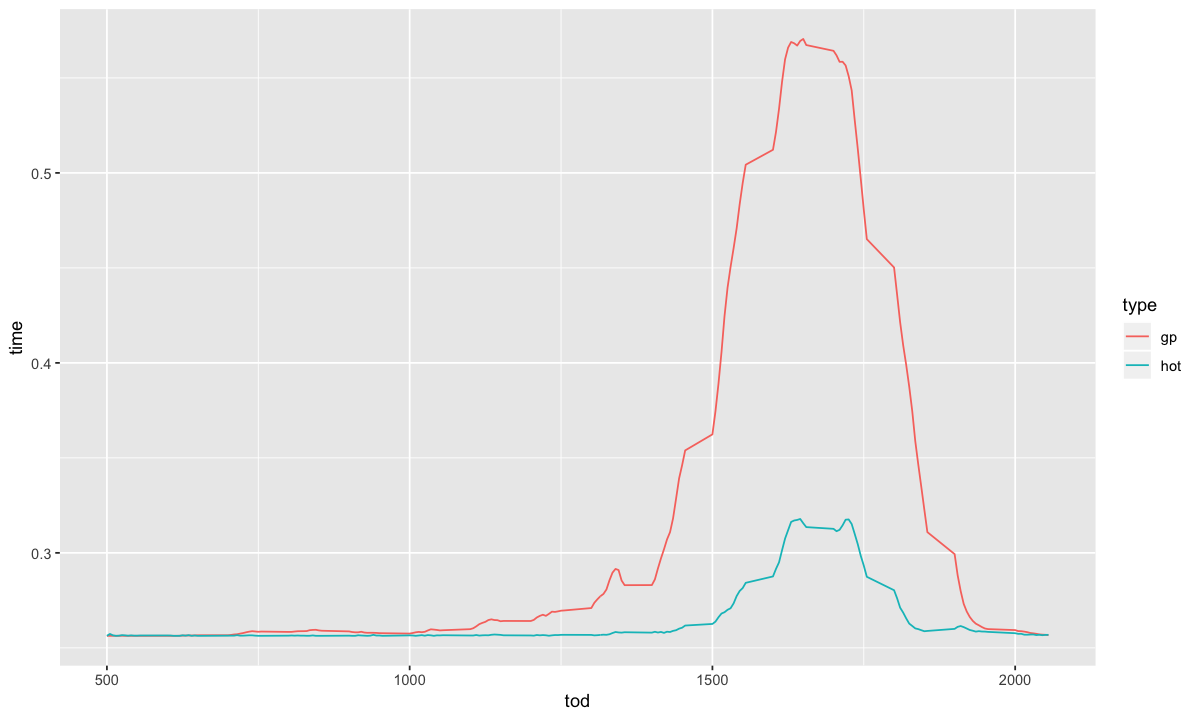

In [5]:
travel_times_nb %>% 
    select(-time, -ts, -date, -savings) %>% 
    group_by(tod) %>%
    summarize_all(mean, na.rm=T) %>%
    gather(type, time, -tod, -hour) %>% 
ggplot(aes(tod, time, color=type)) +
    geom_line()

In [6]:
exp_savings_reliability = travel_times_nb %>% 
    group_by(tod) %>%
    summarize(savings = median(savings, na.rm=T),
              reliability_HOT = quantile(hot, 0.8, na.rm=T) - median(hot, na.rm=T),
              reliability_GP = quantile(gp, 0.8, na.rm=T) - median(gp, na.rm=T),
              reliability = reliability_GP - reliability_HOT)
tail(exp_savings_reliability, 30)

tod,savings,reliability_HOT,reliability_GP,reliability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1830,0.084416667,0.0038944444,0.120333333,0.116438889
1835,0.076625000,0.0000000000,0.095511111,0.095511111
1840,0.058791667,0.0001888889,0.097613889,0.097425000
1845,0.051527778,0.0000000000,0.079602778,0.079602778
1850,0.042666667,0.0000000000,0.074555556,0.074555556
1855,0.027972222,0.0000000000,0.066361111,0.066361111
1900,0.017138889,0.0047722222,0.061230556,0.056458333
1905,0.009847222,0.0048277778,0.046966667,0.042138889
1910,0.004444444,0.0049833333,0.036658333,0.031675000


In [7]:
db_path = "../../../data/hot.db"
trips_u_raw = load_table(db_path, "trips_linked")

In [ ]:
trips_raw = load_table(db_path, "trips_2pct", 
                        c(tag_id="c", acct="c", plate="c", id="c", zip="c")) %>% 
    execute %>%
    mutate(fips=as.character(fips))

In [106]:
trips = trips_u_raw %>%
    filter(entry_plaza==3, exit_plaza==12, toll > 0) %>%
    select(entry_time, fips, toll) %>%
    execute(col_types="icd") %>%
    mutate(entry_time = as_datetime(entry_time),
           date = yday(entry_time),
           wday = wday(entry_time),
           week = week(entry_time),
           month = month(entry_time),
           hour = hour(entry_time),
           tod = 100*hour(entry_time) + floor(minute(entry_time)/5)*5,
           minute = 100*hour(entry_time) + minute(entry_time)) %>%
    left_join(exp_savings_reliability, by="tod") %>%
    mutate(VOT_naive = toll * savings / (savings + reliability)^2,
           VOR_naive = toll * reliability / (savings + reliability)^2)
head(trips)

entry_time,fips,toll,date,wday,week,month,hour,tod,minute,savings,reliability_HOT,reliability_GP,reliability,VOT_naive,VOR_naive
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02 08:37:40,530330244002,0.75,2,3,1,1,8,835,837,0.0016944444,0,0.001688889,0.001688889,111.01944,110.65544
2018-01-02 06:16:47,NA,0.75,2,3,1,1,6,615,616,0.0000000000,0,0.000000000,0.000000000,NaN,NaN
2018-01-02 06:06:29,530530718071,0.75,2,3,1,1,6,605,606,0.0000000000,0,0.000000000,0.000000000,NaN,NaN
2018-01-02 07:22:15,530330093002,0.75,2,3,1,1,7,720,722,0.0006111111,0,0.001000000,0.001000000,176.57551,288.94174
2018-01-02 09:18:24,NA,0.75,2,3,1,1,9,915,918,0.0010833333,0,0.002027778,0.002027778,83.94452,157.12691
2018-01-02 07:44:14,530610419013,0.75,2,3,1,1,7,740,744,0.0018611111,0,0.001500000,0.001500000,123.55713,99.58336


In [107]:
nrow(trips)
summary(trips$VOT_naive)
summary(trips$VOR_naive)

[1] 338891

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   0.000    4.898   14.534   24.084   23.081 1121.250    14335 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   0.478    5.408    8.711   88.917   55.527 4450.549    14335 

Warning message:
“Removed 14374 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 22580 rows containing non-finite values (stat_boxplot).”

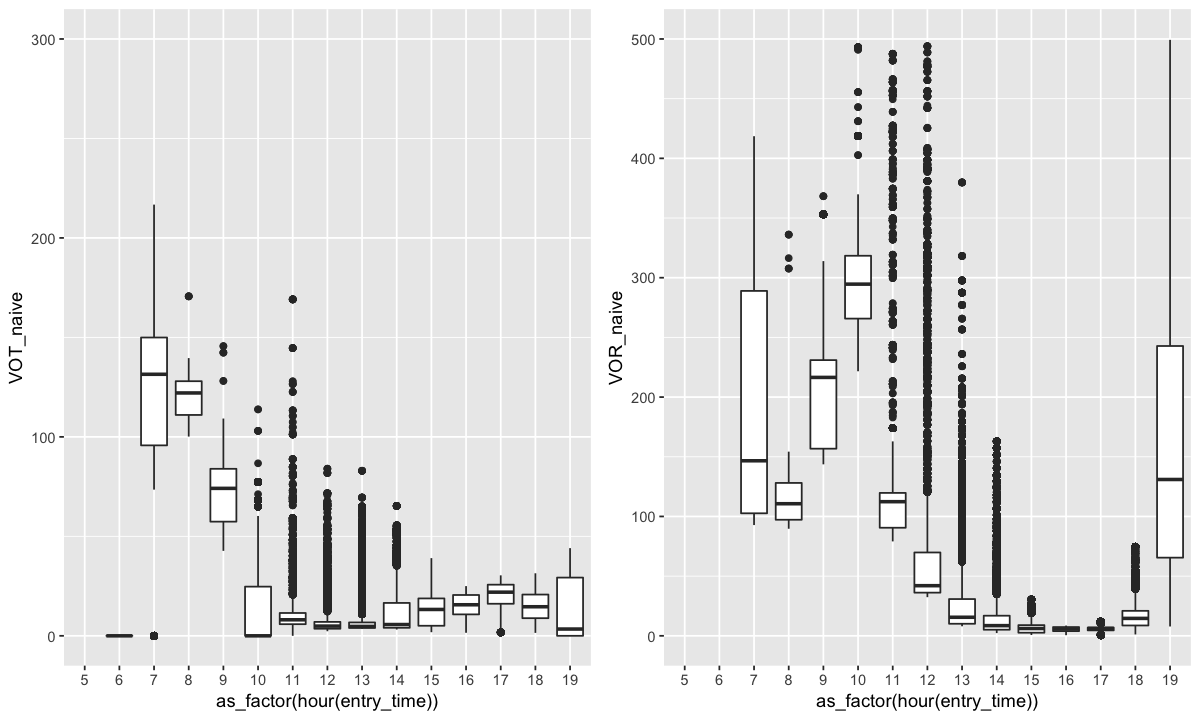

In [109]:
gridExtra::grid.arrange(
    ggplot(trips, aes(as_factor(hour(entry_time)), VOT_naive)) + geom_boxplot() + ylim(0, 300),
    ggplot(trips, aes(as_factor(hour(entry_time)), VOR_naive)) + geom_boxplot() + ylim(0, 500),
    nrow=1)

In [55]:
time.d = trips %>%
    mutate(ts = sprintf("%03i_%04i", date, tod)) %>%
    left_join(select(acs, fips, mean_inc), by="fips") %>%
    left_join(select(travel_times_nb, ts, gp, true_savings=savings), by="ts") %>%
    mutate(ts = sprintf("%03i_%04i", date, minute)) %>%
    arrange(entry_time) %>%
    group_by(ts) %>%
    summarize(inc = mean(mean_inc, na.rm=T)/1000 - 115,
              toll = mean(toll),
              tod = mean(tod),
              hour = mean(hour),
              peak = (hour >= 5 & hour < 9) | (hour >= 15 & hour < 19),
              wday = mean(wday),
              month = mean(month),
              day = mean(date),
              week = mean(week),
              count = n(),
              gp_sp = mean(15/gp),
              savings = mean(savings),
              true_savings = mean(true_savings),
              reliability = mean(reliability))

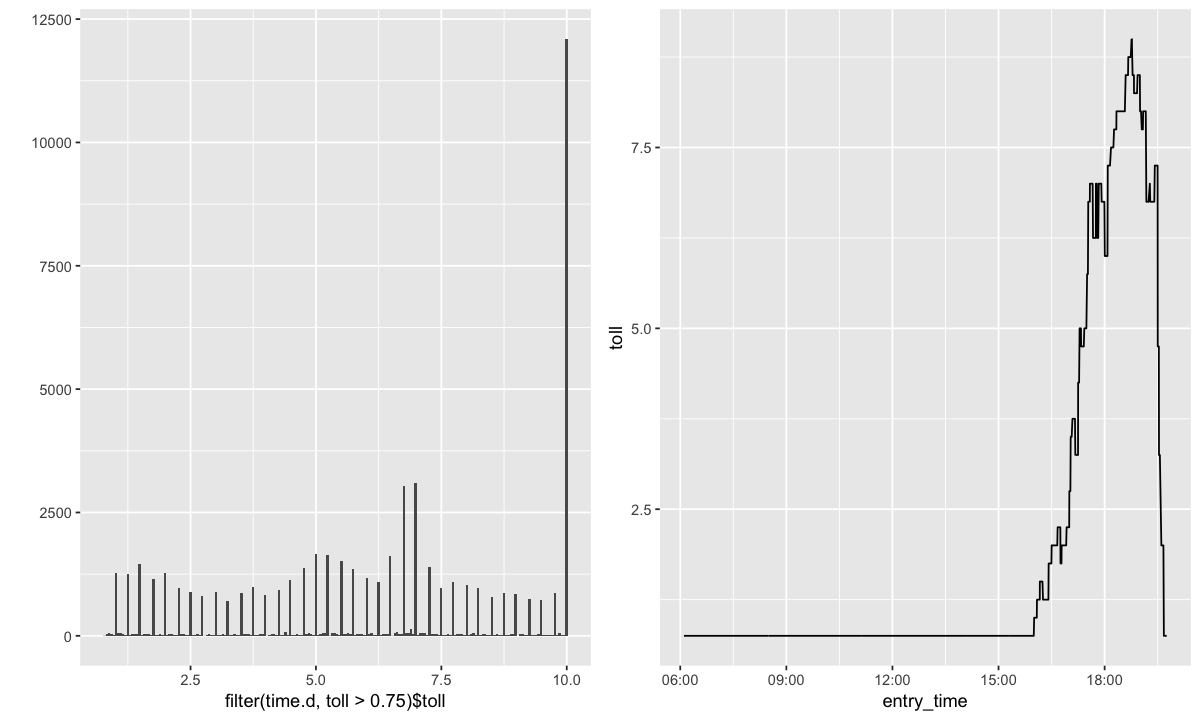

In [12]:
gridExtra::grid.arrange(
    qplot(filter(time.d, toll>0.75)$toll, bins=200),
    ggplot(filter(trips, date==3), aes(entry_time, toll)) + geom_line(),
    nrow=1)

In [13]:
diff.d = time.d %>%
    mutate_at(vars(-ts, -wday, -tod), function(x) x - lag(x))

In [92]:
m = lm(count ~ gp_sp + savings*inc + reliability*inc + toll*inc, data=time.d)
m = lm(count ~ gp_sp + savings + reliability + toll, data=time.d)
summary(m)


Call:
lm(formula = count ~ gp_sp + savings + reliability + toll, data = time.d)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5660 -0.6951 -0.5907  0.4292 13.7893 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.1561792  0.0443205   93.78   <2e-16 ***
gp_sp       -0.0431040  0.0007477  -57.65   <2e-16 ***
savings      2.5420514  0.0923232   27.53   <2e-16 ***
reliability  6.0869624  0.1863401   32.67   <2e-16 ***
toll        -0.0575312  0.0020734  -27.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.44 on 139452 degrees of freedom
  (3920 observations deleted due to missingness)
Multiple R-squared:  0.252,	Adjusted R-squared:  0.252 
F-statistic: 1.175e+04 on 4 and 139452 DF,  p-value: < 2.2e-16


In [15]:
fit.m = function(data, idx) coef(lm(m$call[[2]], data=data[idx,])) 

In [16]:
mb = boot(time.d, statistic=fit.m, R=100, strata=time.d$month, parallel="multicore", stype="i")

In [17]:
left_join(broom::tidy(mb), broom::tidy(m), by=c("term", "statistic"="estimate")) %>%
    select(-statistic.y, -p.value) %>%
    mutate(ratio=std.error.x/std.error.y) %>%
    mutate_at(vars(-term), round, 4)

term,statistic,bias,std.error.x,std.error.y,ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.1562,-0.0004,0.0567,0.0443,1.2802
gp_sp,-0.0431,0.0000,0.0009,0.0007,1.2691
savings,2.5421,-0.0017,0.1147,0.0923,1.2421
reliability,6.0870,-0.0057,0.2173,0.1863,1.1660
toll,-0.0575,0.0000,0.0025,0.0021,1.1999


In [93]:
scales::dollar(-coef(m)["savings"]/coef(m)["toll"])
scales::dollar(-coef(m)["reliability"]/coef(m)["toll"])

[1] "$44.19"

[1] "$105.80"

In [84]:
ml = lmer(count ~ gp_sp + (toll+savings+reliability) + (savings+reliability|peak), data=time.d)
summary(ml)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.4975 (tol = 0.002, component 1)”

Linear mixed model fit by REML ['lmerMod']
Formula: 
count ~ gp_sp + (toll + savings + reliability) + (savings + reliability |  
    peak)
   Data: time.d

REML criterion at convergence: 492475.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7072 -0.4565 -0.3409  0.3590  8.8266 

Random effects:
 Groups   Name        Variance   Std.Dev. Corr       
 peak     (Intercept)  0.0009684 0.03112             
          savings     48.9001528 6.99286  -0.72      
          reliability  4.7256885 2.17386  -0.90  0.95
 Residual              2.0000824 1.41424             
Number of obs: 139457, groups:  peak, 2

Fixed effects:
              Estimate Std. Error t value
(Intercept)  3.5432127  0.0494953  71.587
gp_sp       -0.0346376  0.0007435 -46.587
toll        -0.0381310  0.0020538 -18.566
savings     13.0041555  4.9483791   2.628
reliability  5.8185563  1.5536810   3.745

Correlation of Fixed Effects:
            (Intr) gp_sp  toll   savngs
gp_sp       -0.888                  

In [87]:
coef(ml)$peak

,(Intercept),gp_sp,toll,savings,reliability
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,3.508113,-0.03463757,-0.03813102,21.64196,8.605085
TRUE,3.578313,-0.03463757,-0.03813102,4.36635,3.032028


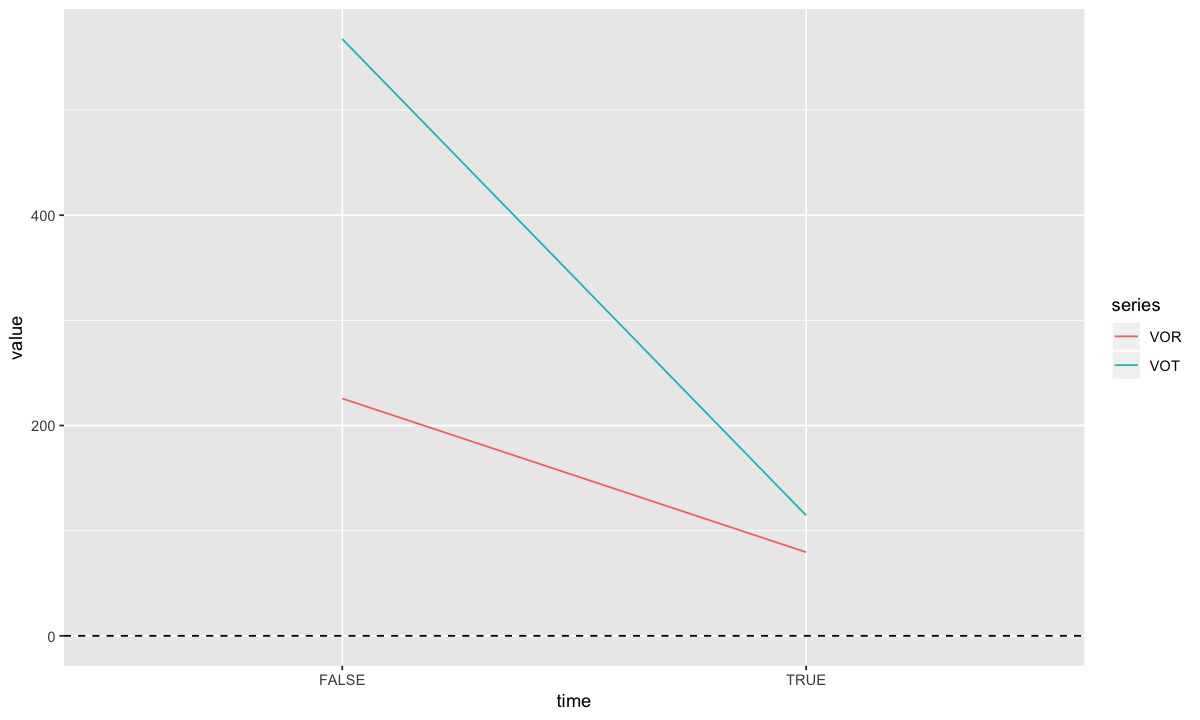

In [88]:
coef(ml)$peak %>%
    #mutate(time = as.numeric(rownames(.)),
    mutate(time = rownames(.),
           VOT = -savings/toll,
           VOR = -reliability/toll) %>%
    select(time, VOT, VOR) %>%
    gather(series, value, -time) %>%
#ggplot(aes(time, toll)) + 
#    geom_line() + 
#    geom_hline(yintercept=0, lty="dashed")
ggplot(aes(time, value, color=series, group=series)) + 
    geom_line() + 
    geom_hline(yintercept=0, lty="dashed")

In [21]:
time.d2 = broom::augment(m, time.d) %>%
    mutate(trip_value = true_savings*(-coef(m)["savings"]/coef(m)["toll"]) + 
               reliability*(-coef(m)["reliability"]/coef(m)["toll"]),
           net_benefit = trip_value - toll)

In [22]:
head(time.d2)

ts,inc,toll,tod,hour,wday,month,day,week,count,⋯,reliability,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid,trip_value,net_benefit
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
002_0606,-67.57651,0.75,605,6,3,1,2,1,1,⋯,0,1.590690,0.005631367,-0.5906896,0.00001528397,1.440446,0.0000005140511,-0.4100783,0.0000000,-0.7500000
002_0613,NaN,0.75,610,6,3,1,2,1,1,⋯,0,1.590690,0.005631367,-0.5906896,0.00001528397,1.440446,0.0000005140511,-0.4100783,0.0000000,-0.7500000
002_0616,98.35496,0.75,615,6,3,1,2,1,3,⋯,0,1.590690,0.005631367,1.4093104,0.00001528397,1.440442,0.0000029261803,0.9783949,0.0000000,-0.7500000
002_0618,NaN,0.75,615,6,3,1,2,1,1,⋯,0,1.590690,0.005631367,-0.5906896,0.00001528397,1.440446,0.0000005140511,-0.4100783,0.0000000,-0.7500000
002_0621,98.35496,0.75,620,6,3,1,2,1,1,⋯,0,1.590690,0.005631367,-0.5906896,0.00001528397,1.440446,0.0000005140511,-0.4100783,0.0000000,-0.7500000
002_0625,98.35496,0.75,625,6,3,1,2,1,3,⋯,0,1.599135,0.005617039,1.4008654,0.00001520629,1.440442,0.0000028765216,0.9725320,0.0380525,-0.7119475


In [62]:
summarize(time.d2,
         revenue = sum(toll),
         benefits = sum(trip_value, na.rm=T))

revenue,benefits
<dbl>,<dbl>
428296.5,1090172


Warning message:
“Removed 1040 rows containing non-finite values (stat_boxplot).”

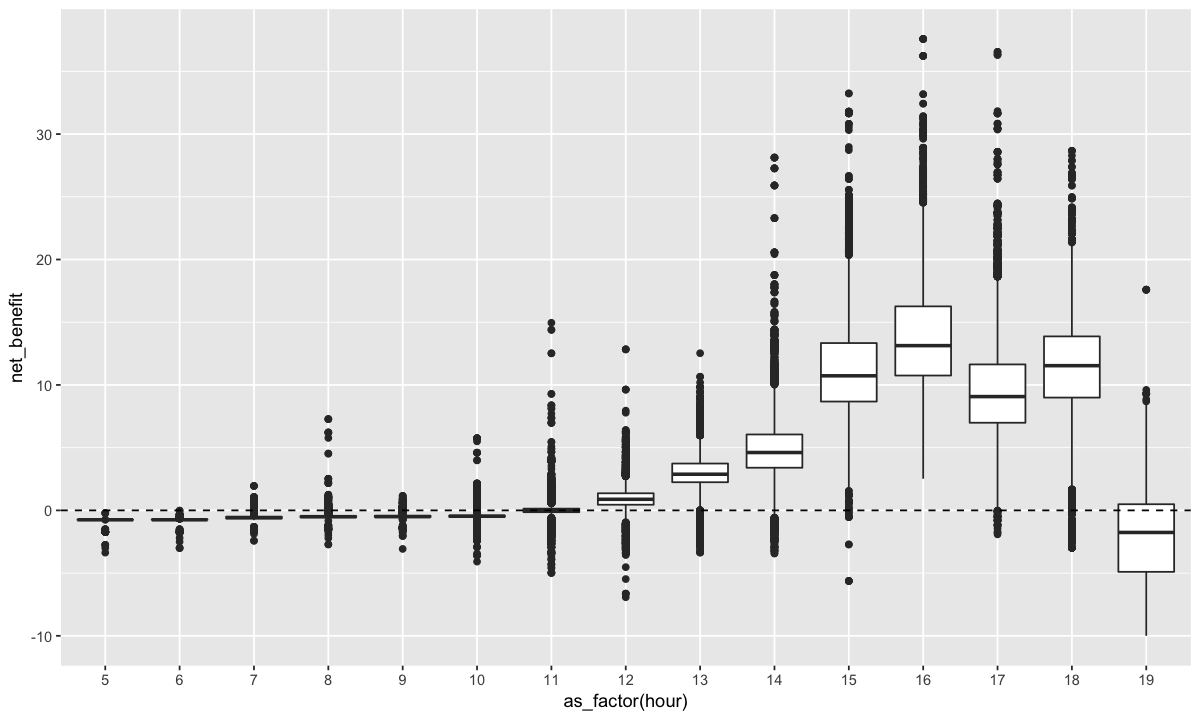

In [23]:
ggplot(time.d2, aes(x=as_factor(hour), y=net_benefit)) + 
    geom_boxplot() +
    geom_hline(yintercept=0, lty="dashed")

Warning message:
“Removed 1040 rows containing non-finite values (stat_boxplot).”

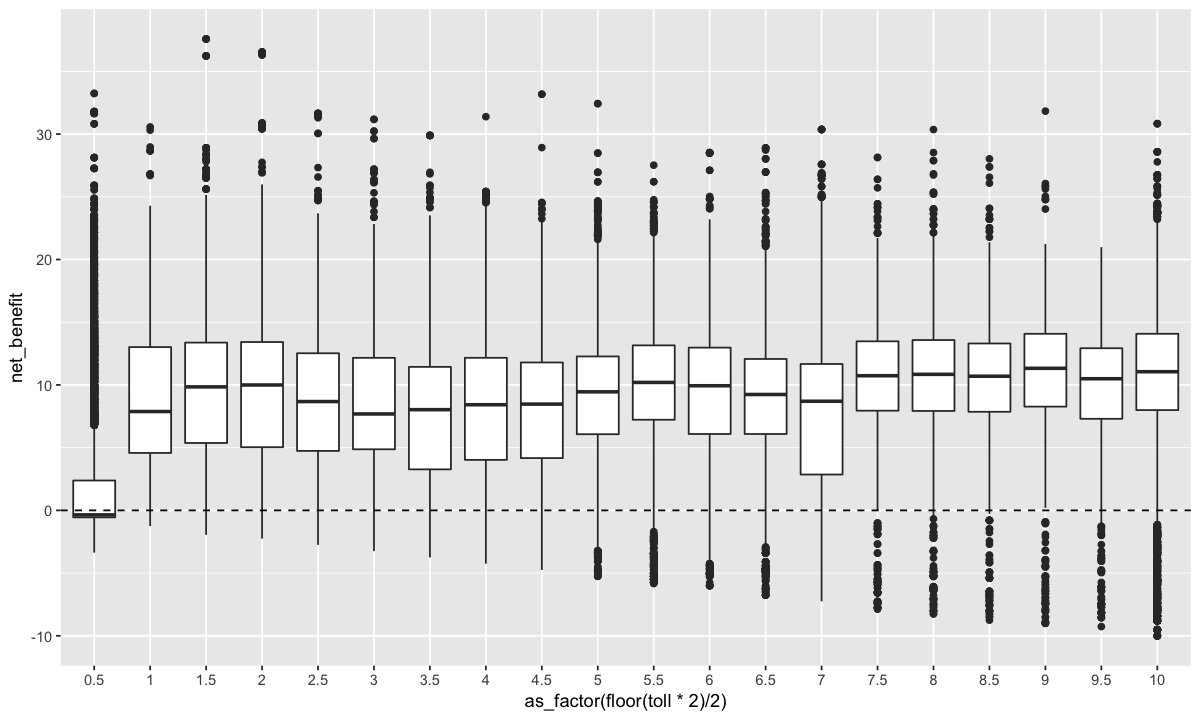

In [105]:
ggplot(time.d2, aes(x=as_factor(floor(toll*2)/2), y=net_benefit)) + 
    geom_boxplot() +
    geom_hline(yintercept=0, lty="dashed")

In [37]:
summary(lm(true_savings ~ savings, data=time.d))


Call:
lm(formula = true_savings ~ savings, data = time.d)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27719 -0.01210 -0.00905  0.00945  0.53155 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0090545  0.0002189   41.37   <2e-16 ***
savings     1.0012603  0.0017890  559.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06425 on 138415 degrees of freedom
  (4960 observations deleted due to missingness)
Multiple R-squared:  0.6935,	Adjusted R-squared:  0.6935 
F-statistic: 3.132e+05 on 1 and 138415 DF,  p-value: < 2.2e-16


Warning message:
“Removed 1040 rows containing missing values (geom_point).”

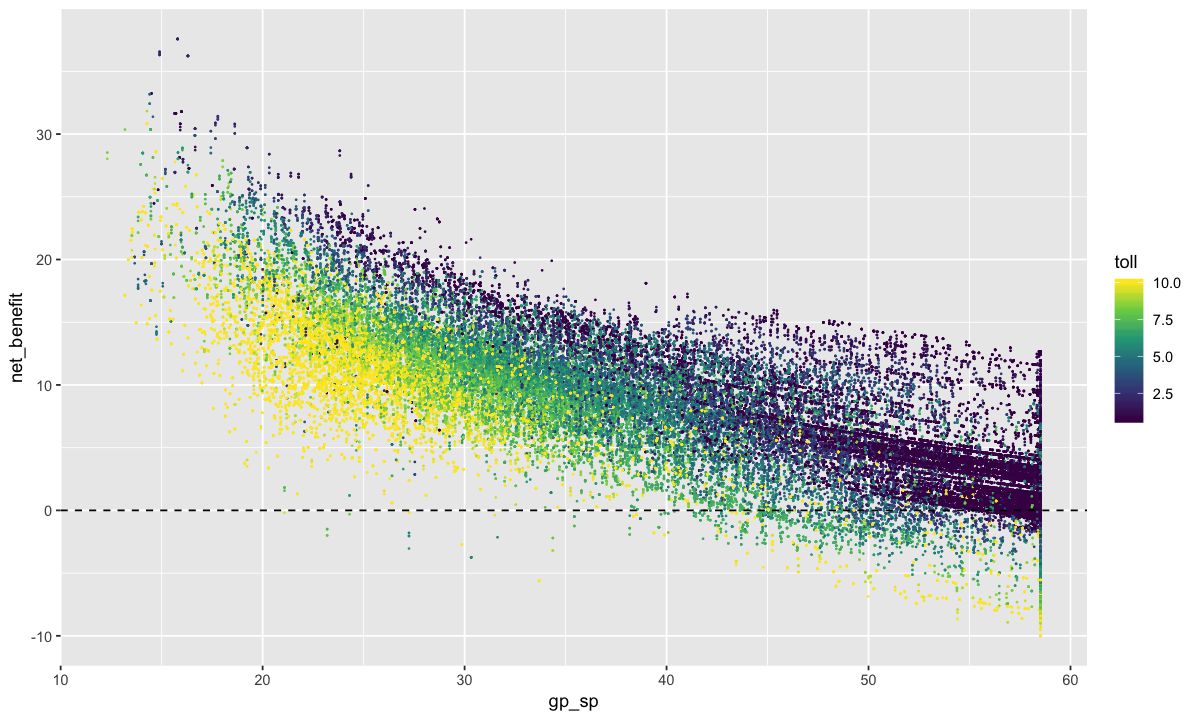

In [96]:
ggplot(time.d2, aes(x=gp_sp, y=net_benefit, color=toll)) + 
    geom_point(size=0.1) + 
    geom_hline(yintercept=0, lty="dashed")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 12494 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 12494 rows containing missing values (geom_point).”

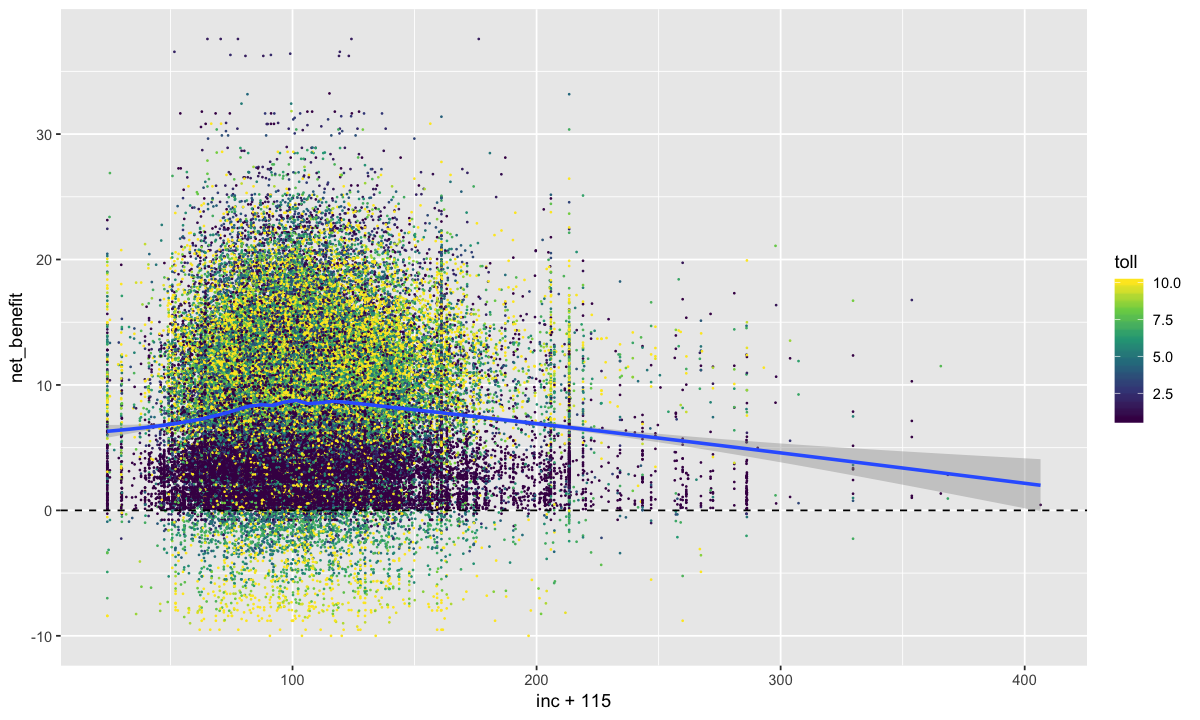

In [103]:
filter(time.d2, hour>=12) %>%
ggplot(aes(x=inc+115, y=net_benefit, color=toll)) + 
    geom_point(size=0.1) + 
    #geom_hex() +
    geom_smooth() +
    geom_hline(yintercept=0, lty="dashed")

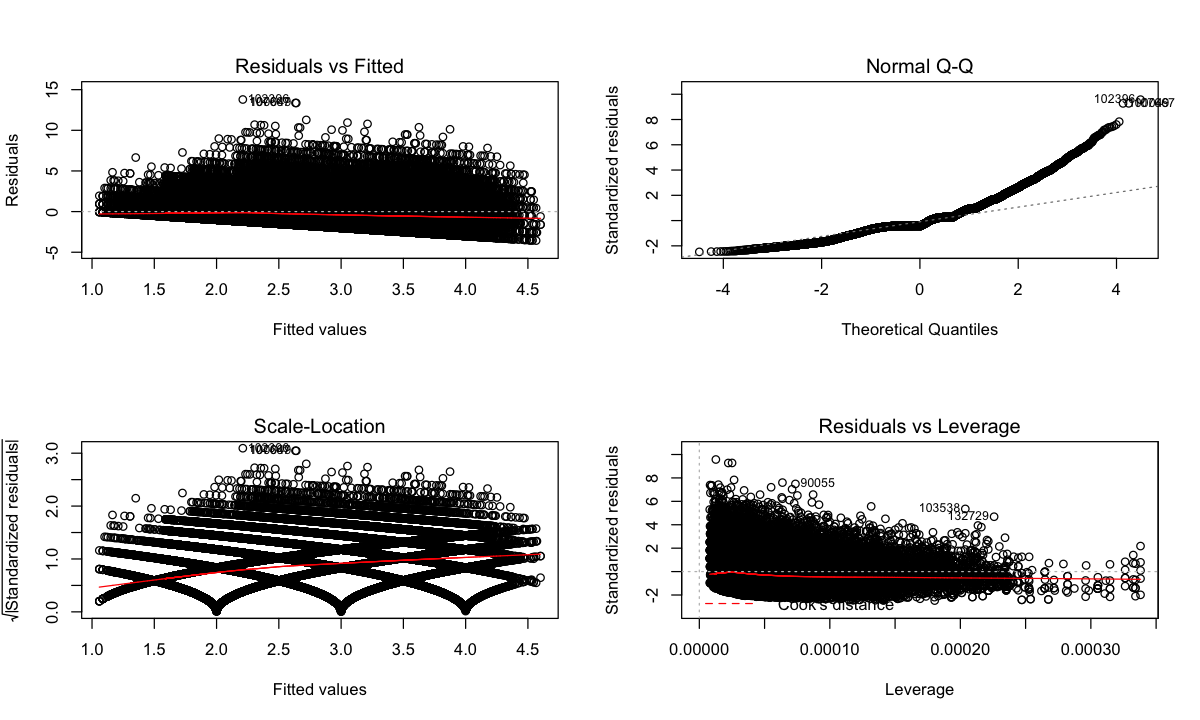

In [54]:
par(mfrow=c(2,2))
plot(m)

## Autocorrelation

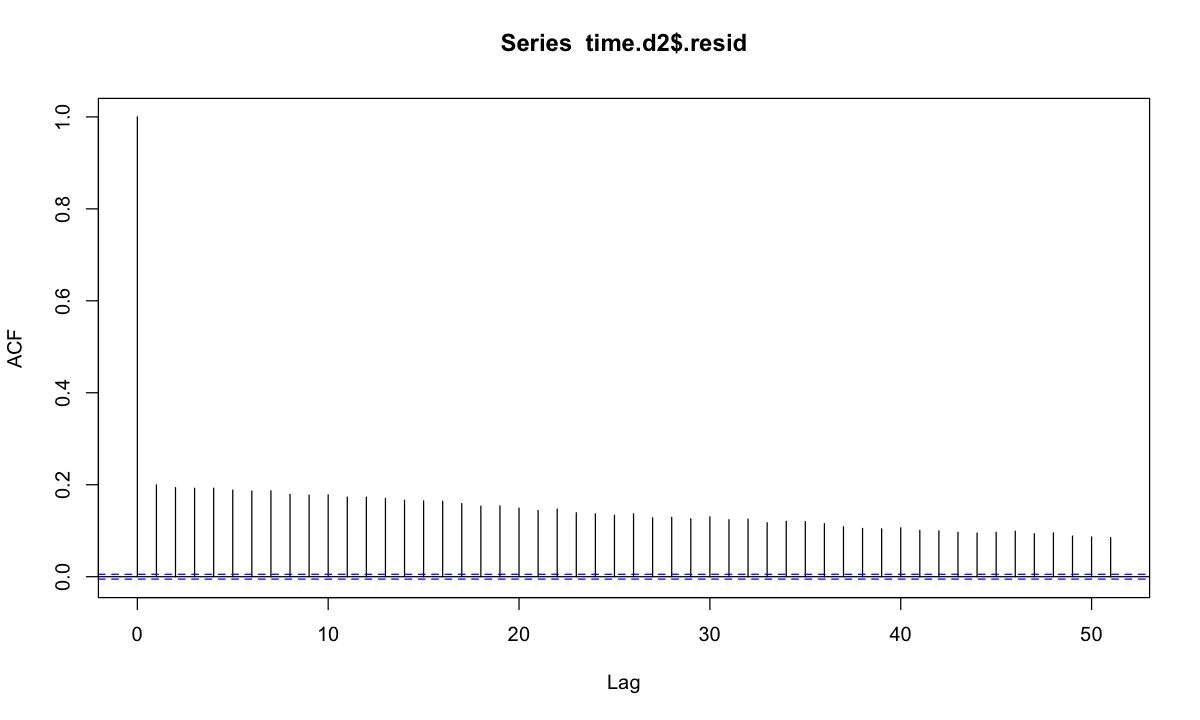

In [48]:
acf(time.d2$.resid)

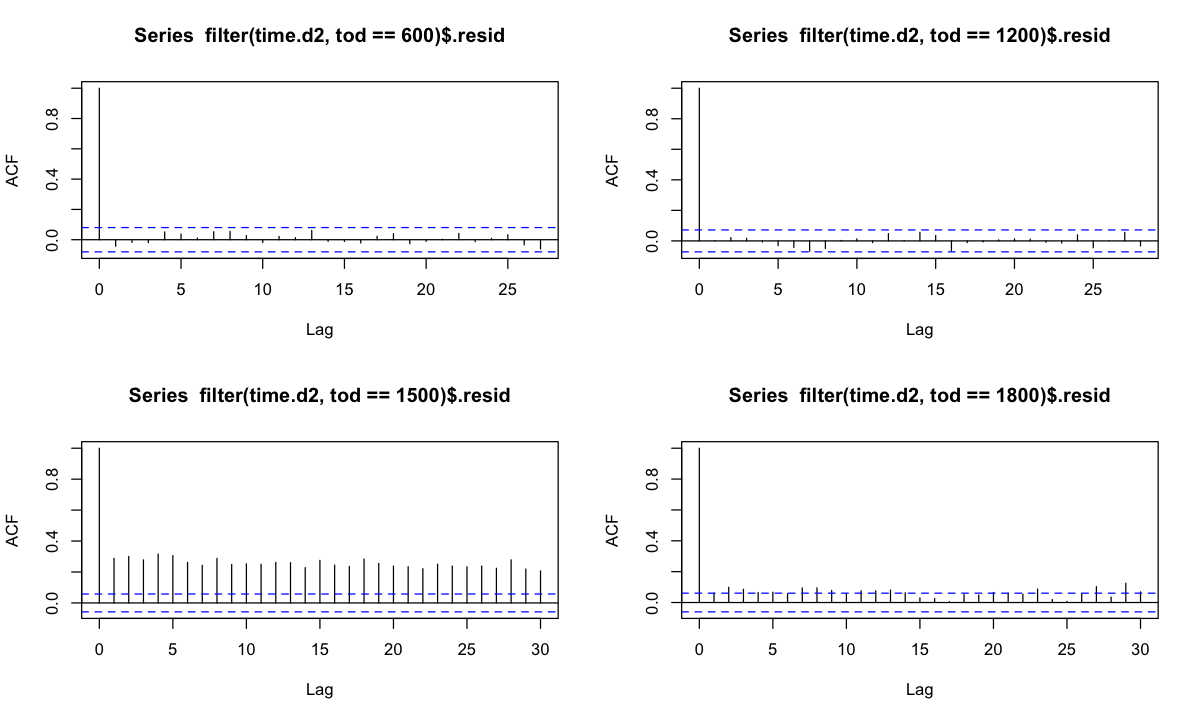

In [27]:
par(mfrow=c(2,2))
acf(filter(time.d2, tod==600)$.resid)
acf(filter(time.d2, tod==1200)$.resid)
acf(filter(time.d2, tod==1500)$.resid)
acf(filter(time.d2, tod==1800)$.resid)

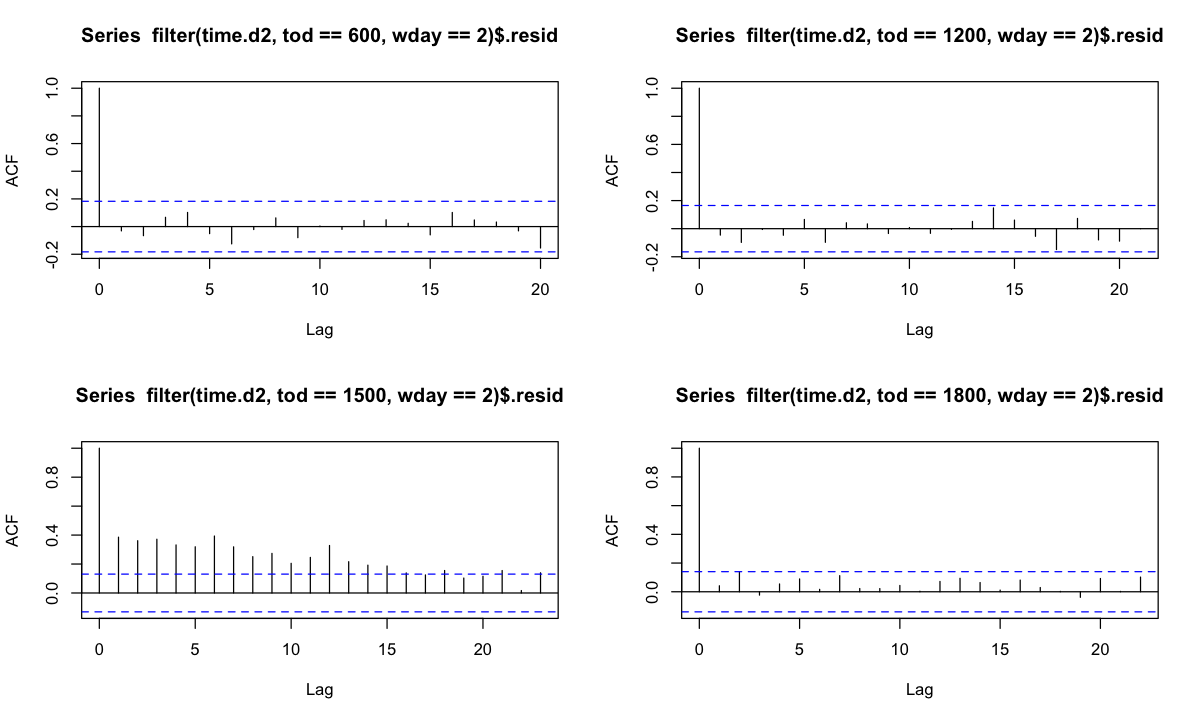

In [28]:
par(mfrow=c(2,2))
acf(filter(time.d2, tod==600, wday==2)$.resid)
acf(filter(time.d2, tod==1200, wday==2)$.resid)
acf(filter(time.d2, tod==1500, wday==2)$.resid)
acf(filter(time.d2, tod==1800, wday==2)$.resid)

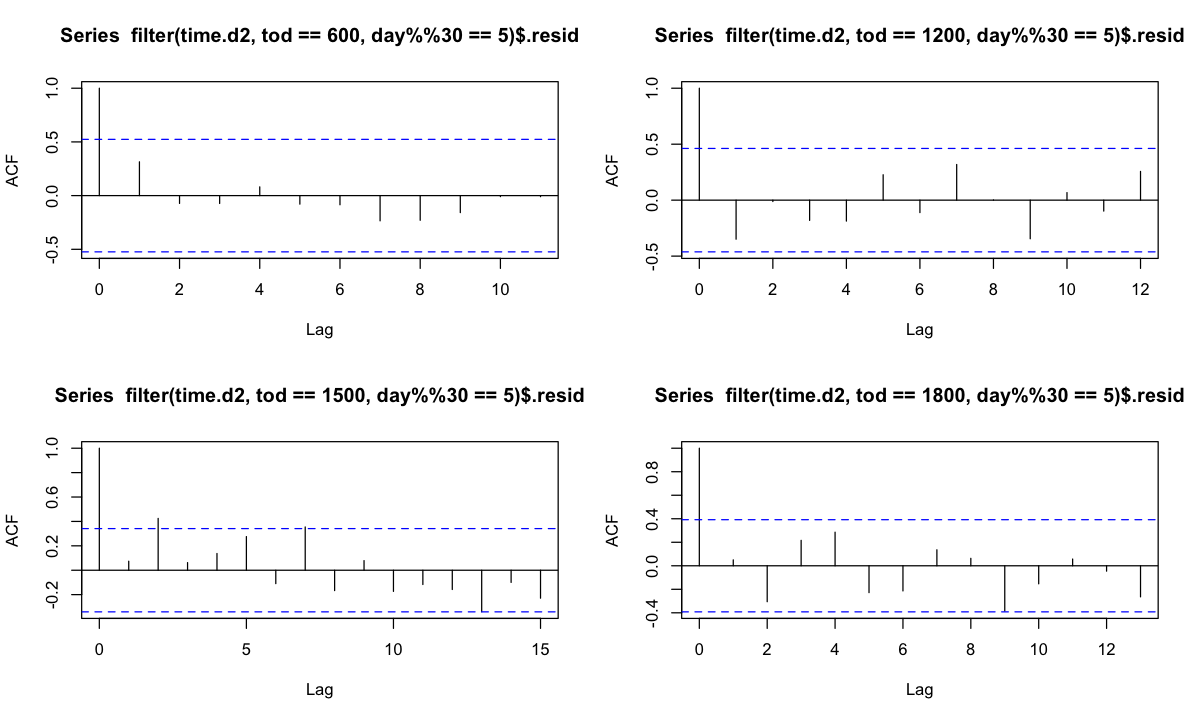

In [42]:
par(mfrow=c(2,2))
acf(filter(time.d2, tod==600,  day%%30==5)$.resid)
acf(filter(time.d2, tod==1200, day%%30==5)$.resid)
acf(filter(time.d2, tod==1500, day%%30==5)$.resid)
acf(filter(time.d2, tod==1800, day%%30==5)$.resid)